In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from tqdm import tqdm
from PIL import Image
import pickle
import models.optimizer.optimizer as optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

# todo: select model here, uncomment to select the model
# from models import Alex_256_relu as m
# from models import Alex_256_sigmoid as m
# from models import Alex_256_tanh as m
# from models import Alex_4096_relu as m
# from models import Alex_4096_tanh as m
from models import VGG16_4096 as m

from helper.training_early_stop import EarlyStop
import helper.utility as utility
import os

In [2]:
# select device
device = utility.select_devices(use_cudnn_if_avaliable=True)

using CUDA + cudnn


# 0. Data Pre-processing

In [3]:
size = (227, 227)
batch_size = 64

data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize(size),
    transforms.ToTensor(),
])

# data augmentation, increase sample size
utility.create_augmentation_dataset('../dataset/train/', 'dataset1_disgust', 'disgust')
data_transforms_R = utility.grayscale_transform_rotation(1, size, 45)
data_transforms_vf = utility.grayscale_transform_verticalflip(1, size, 1.0)
data_transforms_hf = utility.grayscale_transform_horizontalflip(1, size, 1.0)
data_transforms_crop = utility.grayscale_transform_crop(1, size, scale=(0.3, 1))
data_transforms_translate = utility.grayscale_transform_trainslate(1, size, value=(0.3, 0))
data_transforms_shear = utility.grayscale_transform_shear(1, size, value=(-45, 45))

rotation = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_R)
vertical_flip = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_vf)
horizontal_flip = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_hf)
crop = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_crop)
shear = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_shear)
translate = datasets.ImageFolder('../augmentation_dataset/dataset1_disgust/', transform=data_transforms_translate)

train_dataset1 = datasets.ImageFolder('../dataset/train', transform=data_transforms)
train_dataset1 = ConcatDataset([train_dataset1, rotation, vertical_flip, horizontal_flip, crop, shear, translate])

# dataset1
torch.manual_seed(42)
train_size = int(0.85 * len(train_dataset1))
val_size = len(train_dataset1) - train_size
train_dataset1, val_dataset1 = random_split(train_dataset1, [train_size, val_size])
test_dataset1 = datasets.ImageFolder('../dataset/test', transform=data_transforms)

# dataset2
# train_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/train', transform=data_transforms)
# val_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/valid', transform=data_transforms)
# test_dataset2 = datasets.ImageFolder('../dataset2_MMAFEDB/test', transform=data_transforms)

# dataloader
# train_loader = utility.combine_data(train_dataset1, train_dataset2, batch_size, True, True, 16)
# val_loader = utility.combine_data(val_dataset1, val_dataset2, batch_size, False, True, 16)
# test_loader = utility.combine_data(test_dataset1, test_dataset2, batch_size, False, False, 16)

train_loader = utility.imbalance_combine_data([train_dataset1], batch_size, pin_memory=True, num_workers=16)
val_loader = utility.imbalance_combine_data([val_dataset1], batch_size, pin_memory=True, num_workers=16)
test_loader = utility.imbalance_combine_data([test_dataset1], batch_size)

data augmentation is already created at [../augmentation_dataset/dataset1_disgust/]
Train label:
Label 2: 3495 samples
Label 0: 3422 samples
Label 4: 4186 samples
Label 3: 6122 samples
Label 5: 4150 samples
Label 1: 2587 samples
Label 6: 2694 samples
val label:
Label 0: 579 samples
Label 2: 608 samples
Label 5: 686 samples
Label 6: 483 samples
Label 4: 785 samples
Label 3: 1099 samples
Label 1: 465 samples
Test label:
Label 0: 958 samples
Label 1: 111 samples
Label 2: 1024 samples
Label 3: 1774 samples
Label 4: 1233 samples
Label 5: 1247 samples
Label 6: 831 samples
adjusted weights: OrderedDict([(2, 1.0908645003065605), (0, 1.1141354262336145), (4, 0.9107910722817555), (3, 0.6227656694824287), (5, 0.9186919104991395), (1, 1.473742338063946), (6, 1.4152083996181992)])


# 0.1 check data detial

In [ ]:
# check if the size of each label is balanced
print('Train label:')
train_label_count = utility.check_label_size(train_loader)
print('val label:')
val_label_count = utility.check_label_size(val_loader)
print('Test label:')
test_label_count = utility.check_label_size(test_loader)

# 0.2 Test Transform

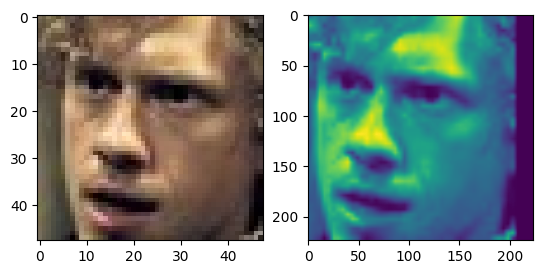

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('../dataset2_MMAFEDB/train/disgust/20573Exp1angry_son_447.jpg')

transformer_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0)),
    transforms.Resize((224, 224)), 
])
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(transformer_test(img))
plt.show()

# 1. Model parameter

In [5]:
# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

In [ ]:
# adjust the weight of each label
class_weights = utility.balance_weight(train_label_count, len(train_loader), batch_size)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()))).to(device)
criterion = nn.CrossEntropyLoss()

In [6]:
# todo: select optimizer
optimizer_name = "Adam"  # or "SGD"
# optimizer_name = "SGD"

# saving path
m.update_file_name(optimizer_name + "_Augmentation_all")

# initialize model, loss-function and optimizer
model = m.EmotionCNN(num_classes=7)  # FER-2013 has 7 emotion class
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = optimizer.create_optimizer(model.parameters(), optimizer_name)

lr_scheduler = ReduceLROnPlateau(
            optimizer,
            mode='max',                 # 'max' for monitoring validation accuracy
            factor=0.4,                 # factor by which the learning rate will be reduced
            patience=3,                 # number of epochs with no improvement to trigger LR reduction
            min_lr=1e-7,                # minimum learning rate
            verbose=1                   # (1: print messages, 0: not print message)
        )

In [7]:
# training model
num_epochs = 2000

# early stopping variables
stop_counter = 10 # number of count to trigger early stop
stop_counter_window = 15 # a range to check stop_counter
different = 0.001 # different between the best val loss and the most recent one
stop_counter_interval = 30 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after =0
early_stopping = EarlyStop(m.pth_save_path, stop_counter, different, type="accuracy")

# 2. Model training

In [8]:
model.to(device)

# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        probability = nn.functional.softmax(outputs, dim=1)
        _, prediction = torch.max(probability, dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        correct_prediction_pre_epoch.append(num_correct_prediction)
        accuracy += num_correct_prediction / inputs.shape[0]
    # save training status
    loss_history_per_epoch.append((running_loss / len(train_loader)))
    accuracy_per_epoch.append((accuracy / len(train_loader)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch% stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                probability = nn.functional.softmax(outputs, dim=1)
                _, prediction = torch.max(probability, dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        early_stopping.check_status(model, val_accuracy)

        # display recently 5 average loss of epochs
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"val loss= {'{:.5f}'.format(val_loss_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])} - "
                                f"val accuracy= {'{:.3%}'.format(val_accuracy_per_epoch[-1])} - "
                                f"best= {'{:.3%}'.format(early_stopping.best_of_all_value)} - "
                                f"Counter= {early_stopping.counter}/{stop_counter}")
    else:
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])}")

    if early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        early_stopping.early_stop = False
        break

loss= 1.53834 - val loss= 1.36603 - accuracy= 40.591% - val accuracy= 49.244% - best= 49.244% - Counter= 0/10:   0%|                    | 2/2000 [03:00<49:47:21, 89.71s/epoch]

# 3. Save model and records

In [ ]:
# save the pth file
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

# 4. Plot records and Evaluation

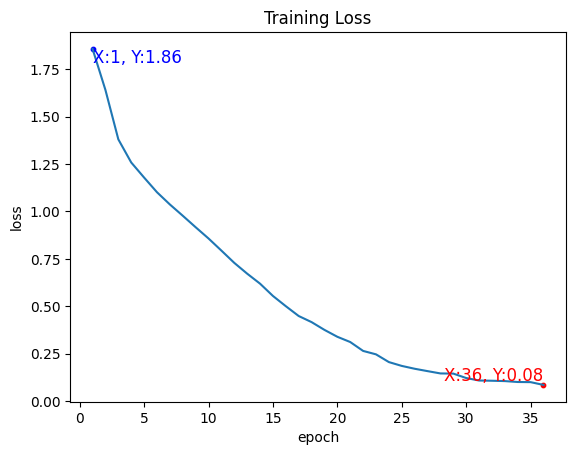

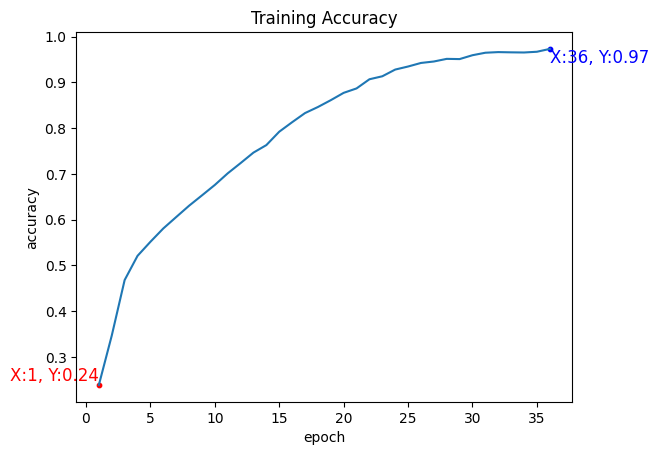

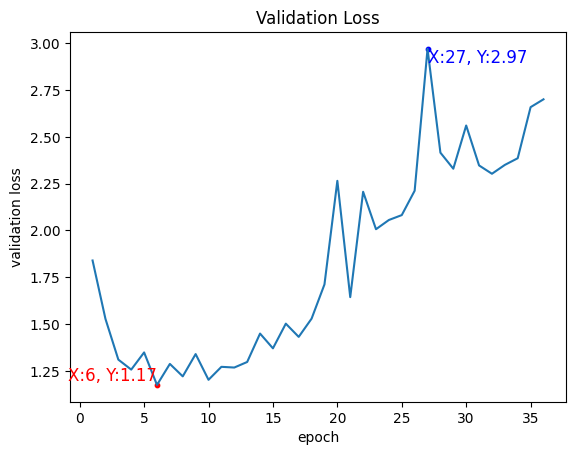

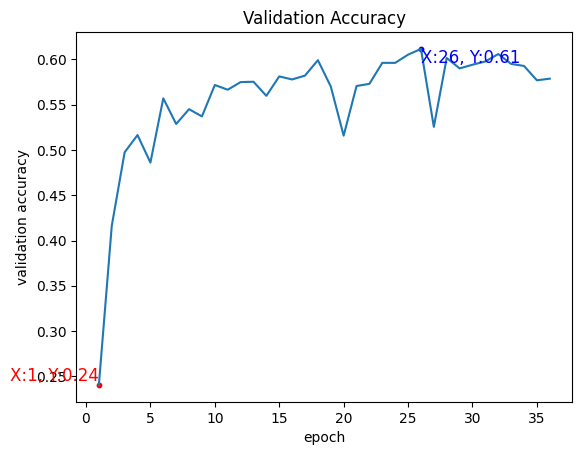

In [ ]:
# draw graphs
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy",
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation loss",
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(
    m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation accuracy",
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")


model weight path: ./model_data/VGG16_4096_Adam_Augmentation_c/model.pth
Test Accuracy: 61.507383672332125%
              precision    recall  f1-score   support

           0       0.51      0.54      0.53       958
           1       0.45      0.58      0.50       111
           2       0.52      0.31      0.39      1024
           3       0.81      0.83      0.82      1774
           4       0.57      0.57      0.57      1233
           5       0.47      0.53      0.50      1247
           6       0.71      0.80      0.75       831

    accuracy                           0.62      7178
   macro avg       0.58      0.60      0.58      7178
weighted avg       0.61      0.62      0.61      7178

Test Accuracy: 58.108108108108105%
              precision    recall  f1-score   support

           0       0.59      0.42      0.49       958
           1       0.46      0.51      0.49       111
           2       0.43      0.38      0.41      1024
           3       0.75      0.86      0.80

<Figure size 700x700 with 0 Axes>

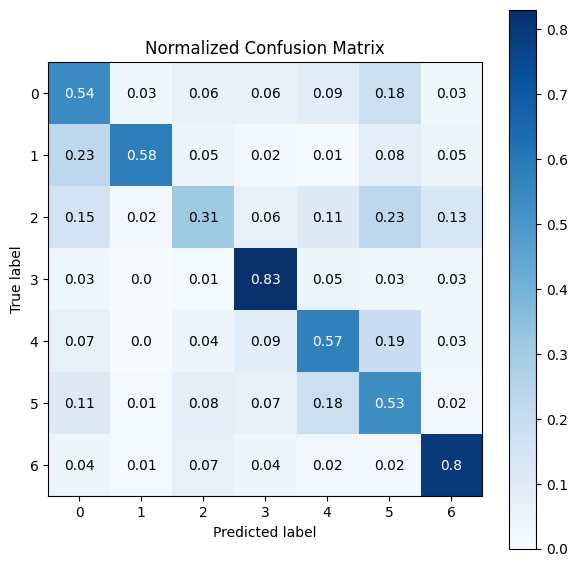

<Figure size 700x700 with 0 Axes>

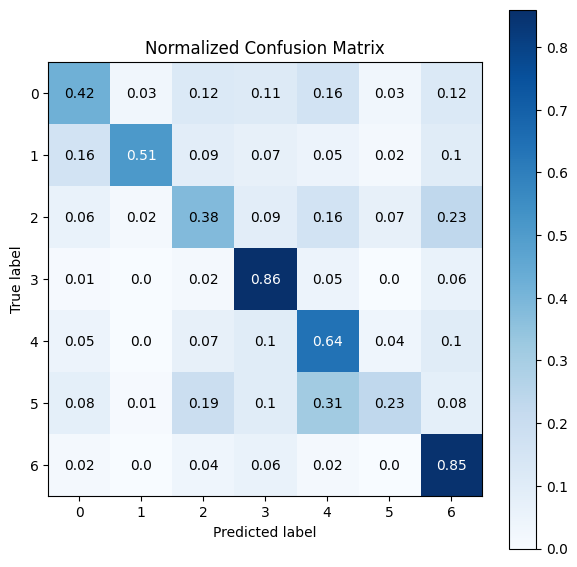

In [ ]:
# evaluate model
model = m.EmotionCNN(num_classes=7)
print(f'model weight path: {m.pth_save_path}')
utility.model_validation(model, device, test_loader, m.pth_save_path, m.record_save_path, file_name='1')
utility.model_validation(model, device, test_loader, m.pth_manual_save_path, m.record_save_path, file_name='2')